<a href="https://colab.research.google.com/drive/10n6iLpV9u8-lHOG2l1WAyObhM7yWQ6Ha#scrollTo=zX4Kg8DUTKWO" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Import stardards libraires

In [ ]:
import json
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# keras kit
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical

from keras.models import Model

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



## Part 1 : Tokenization

In [ ]:
# preprocessing
# create sentences
sentences = [
    'i love my dog',
    'I, love my cat',
    'You love my dog!',
    'Do you think my dog is amazing?'
]

# create a tokenizer object
# "<OOV>" to preserve at least the length of total training data and will be remplaced after the training by the original word
tokenizer = Tokenizer(num_words = 100, oov_token="<OOV>")
# fitting
tokenizer.fit_on_texts(sentences)
# turn the words to numeric tokens
word_index = tokenizer.word_index
print(word_index)

{'<OOV>': 1, 'my': 2, 'love': 3, 'dog': 4, 'i': 5, 'you': 6, 'cat': 7, 'do': 8, 'think': 9, 'is': 10, 'amazing': 11}


## Part 2 : Turning sentences into data

In [ ]:
# create a sequences of numbers related on each token for each sentences
sequences = tokenizer.texts_to_sequences(sentences)

# RaggerTensor to turn the sequences into a matrix with the same lenght
# second method is using padding method
# padding shape the matrix based on the lenght of the longuest sequence
# and  add bunch of zeros to the small ones
padded = pad_sequences(sequences)
# padded = pad_sequences(sequences, padding='post', truncating='post', maxlen=5)

print(sequences)
print(padded)

[[5, 3, 2, 4], [5, 3, 2, 7], [6, 3, 2, 4], [8, 6, 9, 2, 4, 10, 11]]
[[ 0  0  0  5  3  2  4]
 [ 0  0  0  5  3  2  7]
 [ 0  0  0  6  3  2  4]
 [ 8  6  9  2  4 10 11]]


In [ ]:
# testing data
"""
test results :

[[3, 1, 2, 4], [2, 4, 2]]

/!\can't create the new words that where not initialized in the training dataset
To solve this we add the oov_token"<OOV>" to preserve at least the length of total training data
"""
test_data = [
    'i really love my dog',
    'my dog loves my manatee'
]

test_seq = tokenizer.texts_to_sequences(test_data)
print(test_seq)


[[5, 1, 3, 2, 4], [2, 4, 1, 2, 1]]


## Part 3 : Training model to recognize sentiment in text

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2021-03-17 00:55:54--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.02s   

2021-03-17 00:55:54 (223 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [ ]:
# !cat /tmp/sarcasm.json

Initialization

In [ ]:
# initialization

vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

Preprocesssing

In [ ]:
# preprocessing

# loading data
with open("/tmp/sarcasm.json", 'r') as f:
  datastore = json.load(f)

# preparing training data
sentences = []
labels = []
urls = []

for item in datastore:
  sentences.append(item['headline'])
  labels.append(item['is_sarcastic'])
  urls.append(item['article_link'])

# slicing training and testing data for the model
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# create a tokenizer object
# "<OOV>" to preserve at least the length of total training data and will be remplaced after the training by the original word
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
# fitting training sentences
tokenizer.fit_on_texts(training_sentences)
# turn the words to numeric tokens
word_index = tokenizer.word_index

# create a sequences of tokens for training
training_sequences = tokenizer.texts_to_sequences(training_sentences)
# RaggerTensor to turn the sequences into a matrix with the same lenght
# second method is using padding method
# padding shape the matrix based on the lenght of the longuest sequence
# and  add bunch of zeros to the small ones
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# create a sequences of tokens for testing
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
# checking data
print(training_padded.shape)
print(testing_padded.shape)
print(word_index)
print(training_sequences)
print(training_padded)
print(testing_sequences)
print(testing_padded)


(20000, 100)
(6709, 100)
{'<OOV>': 1, 'to': 2, 'of': 3, 'the': 4, 'in': 5, 'for': 6, 'a': 7, 'on': 8, 'and': 9, 'with': 10, 'is': 11, 'new': 12, 'trump': 13, 'man': 14, 'from': 15, 'at': 16, 'about': 17, 'you': 18, 'by': 19, 'this': 20, 'after': 21, 'be': 22, 'up': 23, 'out': 24, 'that': 25, 'how': 26, 'as': 27, 'it': 28, 'not': 29, 'are': 30, 'your': 31, 'what': 32, 'his': 33, 'all': 34, 'he': 35, 'will': 36, 'who': 37, 'just': 38, 'has': 39, 'more': 40, 'one': 41, 'year': 42, 'into': 43, 'report': 44, 'have': 45, 'why': 46, 'over': 47, 'area': 48, 'u': 49, 'donald': 50, 'says': 51, 'day': 52, 'can': 53, 's': 54, 'first': 55, 'woman': 56, 'time': 57, 'like': 58, 'get': 59, 'old': 60, 'no': 61, 'her': 62, "trump's": 63, 'off': 64, 'now': 65, 'an': 66, 'obama': 67, 'life': 68, 'people': 69, 'women': 70, 'house': 71, "'": 72, 'was': 73, 'still': 74, 'white': 75, 'back': 76, 'make': 77, 'than': 78, 'clinton': 79, 'down': 80, 'when': 81, 'my': 82, '5': 83, 'could': 84, 'world': 85, 'americ

In [ ]:
# Need this block to get it to work with TensorFlow 2.x
# Convert list to array
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

Model

In [ ]:
# model =Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.Dense(24, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# create linear model
model = Sequential()
# Add embedding (word2vec) vectors : input nodes of words = 16x10000 = 160000
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
# add 1D pooling filter
model.add(GlobalAveragePooling1D())
# 24 nodes : hidden nodes with relu first activation function
model.add(Dense(24, activation='relu'))
# output layer with sigmoid output activation function
model.add(Dense(1, activation='sigmoid'))
adam = Adam(lr=0.001)
# compile model
model.compile(loss='binary_crossentropy', optimizer= adam, metrics=['accuracy'])

In [ ]:
# summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d_7 ( (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 24)                408       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# training history
h = model.fit(training_padded, training_labels, validation_data=(testing_padded, testing_labels),
              epochs=10, batch_size = 50, verbose=1, shuffle= 1)

Epoch 1/10
400/400 [==============================] - 3s 5ms/step - loss: 0.6847 - accuracy: 0.5561 - val_loss: 0.6438 - val_accuracy: 0.5755
Epoch 2/10
400/400 [==============================] - 2s 5ms/step - loss: 0.5848 - accuracy: 0.6984 - val_loss: 0.4260 - val_accuracy: 0.8354
Epoch 3/10
400/400 [==============================] - 2s 4ms/step - loss: 0.3638 - accuracy: 0.8659 - val_loss: 0.3651 - val_accuracy: 0.8518
Epoch 4/10
400/400 [==============================] - 2s 4ms/step - loss: 0.2865 - accuracy: 0.8931 - val_loss: 0.3502 - val_accuracy: 0.8521
Epoch 5/10
400/400 [==============================] - 2s 5ms/step - loss: 0.2419 - accuracy: 0.9078 - val_loss: 0.3417 - val_accuracy: 0.8575
Epoch 6/10
400/400 [==============================] - 2s 4ms/step - loss: 0.2123 - accuracy: 0.9221 - val_loss: 0.3437 - val_accuracy: 0.8563
Epoch 7/10
400/400 [==============================] - 2s 5ms/step - loss: 0.1937 - accuracy: 0.9268 - val_loss: 0.3505 - val_accuracy: 0.8548
Epoch 

Text(0, 0.5, 'loss')

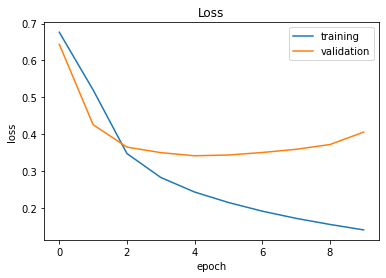

In [ ]:
# plot
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

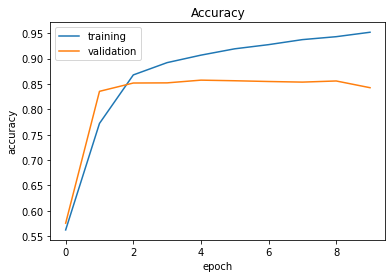

In [ ]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [ ]:
score = model.evaluate(testing_padded, testing_labels, verbose=1)
print(type(score))
print('Test score:', score[0])
print('Test accuracy:', score[1])

210/210 [==============================] - 0s 2ms/step - loss: 0.4058 - accuracy: 0.8426
<class 'list'>
Test score: 0.40583914518356323
Test accuracy: 0.8425995111465454


In [ ]:
# reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# def decode_sentence(text):
#     return ' '.join([reverse_word_index.get(i, '?') for i in text])

# print(decode_sentence(training_padded[0]))
# print(training_sentences[2])
# print(labels[2])

In [ ]:
# e = model.layers[0]
# weights = e.get_weights()[0]
# print(weights.shape) # shape: (vocab_size, embedding_dim)


In [ ]:
# import io

# out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
# out_m = io.open('meta.tsv', 'w', encoding='utf-8')
# for word_num in range(1, vocab_size):
#   word = reverse_word_index[word_num]
#   embeddings = weights[word_num]
#   out_m.write(word + "\n")
#   out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
# out_v.close()
# out_m.close()

In [ ]:
# try:
#   from google.colab import files
# except ImportError:
#   pass
# else:
#   files.download('vecs.tsv')
#   files.download('meta.tsv')

prediction

In [ ]:

sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
prob = model.predict(padded)
print(f"Probability of sarcasm : {str(prob[0])}\nProbability of No sarcasm : {str(prob[1])}" )

Probability of sarcasm : [0.612642]
Probability of No sarcasm : [0.07048358]


## Part 4 : ML with **RNN** (Recurrent Neural Network)

In [ ]:
# creating a RNN for text generation
# RNN vs simple classification model : is that the order of each word in sequence matter!
# ex : fibonacci serie : the previous number of the serie remains useful after creating the next value
# same thing with RNN each

# Strengh : great to predict word from the same family like :  Irland(country) = > Irish (language)
# Weakness : Can't predict the word that are not from the same family : Irland => Galcelic ??
      # To solve this, we use a LSMT


- [RNN implementation](https://colab.research.google.com/drive/1mn6ICfaz01b9_Zloa48vbug_mC2jMjpL#scrollTo=BOwsuGQQY9OL)


## References

- [Natural Language Processing (NLP) Zero to Hero](https://www.youtube.com/playlist?list=PLQY2H8rRoyvzDbLUZkbudP-MFQZwNmU4S)

- [LSTM](#)

